In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path = "../input/"

----
## Exploring the Data


In [2]:
sample_train = pd.read_csv(path + "train_sample.csv")
display(sample_train.head(n=5))

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,29540,3,1,42,489,2017-11-08 03:57:46,NaN,0
1,26777,11,1,25,319,2017-11-09 11:02:14,NaN,0
2,140926,12,1,13,140,2017-11-07 04:36:14,NaN,0
3,69375,2,1,19,377,2017-11-09 13:17:20,NaN,0
4,119166,9,2,15,445,2017-11-07 12:11:37,NaN,0


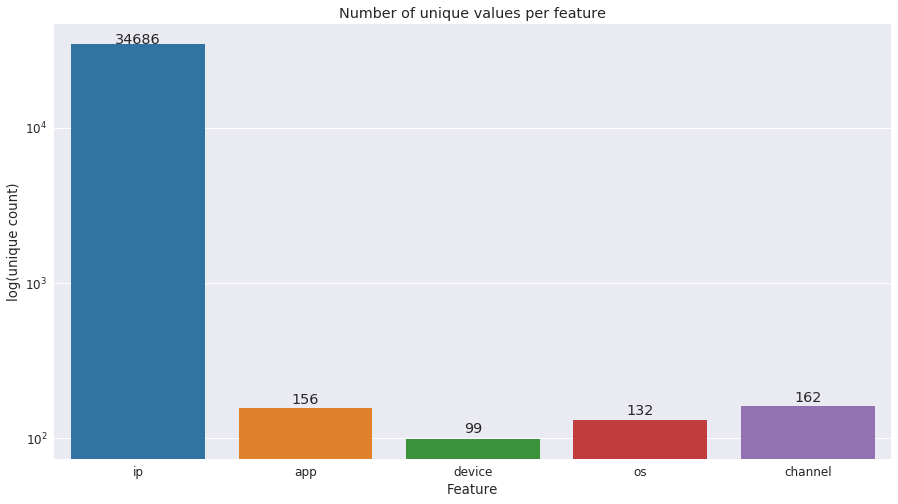

In [3]:
#https://www.kaggle.com/anokas/talkingdata-adtracking-eda
pal = sns.color_palette()
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = sample_train[cols].nunique()
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

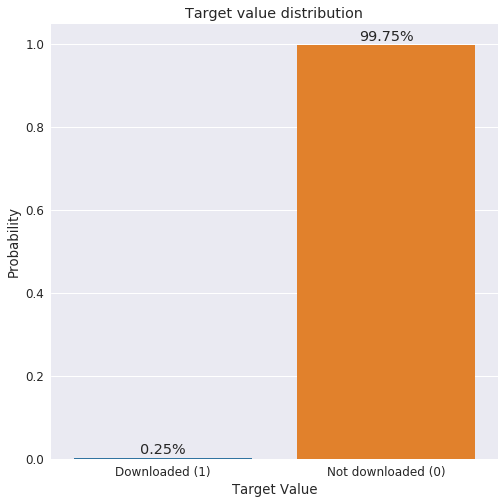

In [4]:
#https://www.kaggle.com/anokas/talkingdata-adtracking-eda
def plot_distribution(dt):
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.2)
    mean = (dt.is_attributed.values == 1).mean()
    n_is_attributed = len(dt[dt.is_attributed==1])
    n_not_attributed = len(dt[dt.is_attributed==0])
    greater_percent = float(n_is_attributed)/float(n_not_attributed)*100
    ax = sns.barplot(['Downloaded (1)', 'Not downloaded (0)'], [mean, 1-mean], palette=pal)
    ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
    for p, uniq in zip(ax.patches, [mean, 1-mean]):
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height+0.01,
                '{}%'.format(round(uniq * 100, 2)),
                ha="center") 
plot_distribution(sample_train)

In [5]:
def print_data_distribution(dt):
    n_records = dt.shape[0]
    n_is_attributed = len(dt[dt.is_attributed==1])
    n_not_attributed = len(dt[dt.is_attributed==0])
    greater_percent = float(n_is_attributed)/float(n_not_attributed)*100
    # Print the results
    print ("Total number of records: {}".format(n_records))
    print ("Clicks downloading app: {}".format(n_is_attributed))
    print ("Clicking not downloading app: {}".format(n_not_attributed))
    print ("Percentage of clicks downloading app: {:.2f}%".format(greater_percent))
    
print_data_distribution(sample_train)
del sample_train;gc.collect()

Total number of records: 100000
Clicks downloading app: 251
Clicking not downloading app: 99749
Percentage of clicks downloading app: 0.25%


3345

----
## Data processing

> ### Upsampling the positive target value data to improve the imblance in the training data

In [6]:
import dask.dataframe as ddf

dtypes = {'ip'            : 'uint32',
          'app'           : 'uint16',
          'device'        : 'uint16',
          'os'            : 'uint16',
          'channel'       : 'uint16',
          'is_attributed' : 'uint8',
          }

dask_df = ddf.read_csv('../input/train.csv',dtype=dtypes)
df_neg = dask_df[(dask_df['is_attributed'] == 0)].compute()
df_neg = df_neg.sample(n=20000)
df_pos = dask_df[(dask_df['is_attributed'] == 1)].compute()
df_pos = df_pos.sample(n=5000)
train = pd.concat([df_pos,df_neg]).sample(frac=1).reset_index()
del dask_df, df_pos, df_neg; gc.collect()

/opt/conda/lib/python3.6/site-packages/dask/local.py:290: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)
/opt/conda/lib/python3.6/site-packages/dask/local.py:290: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)


1752

In [7]:
print_data_distribution(train)

Total number of records: 25000
Clicks downloading app: 5000
Clicking not downloading app: 20000
Percentage of clicks downloading app: 25.00%


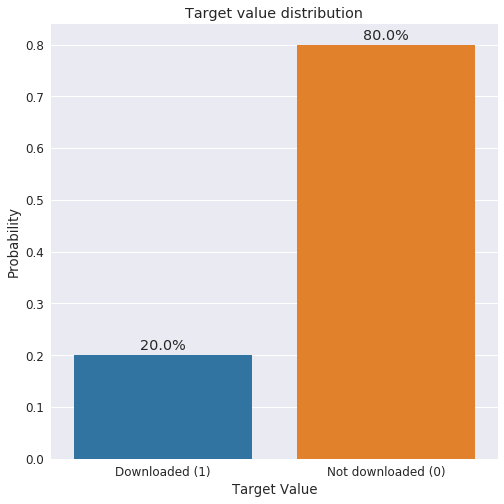

In [8]:
plot_distribution(train)

### Process click time

Split **click_time** into  4 segments  : month, day, hour, minute

In [9]:
def process_time(dt):
    dt['sec'] = pd.to_datetime(dt.click_time).dt.second.astype('uint8')
    dt['min'] = pd.to_datetime(dt.click_time).dt.minute.astype('uint8')
    dt['hour'] = pd.to_datetime(dt.click_time).dt.hour.astype('uint8')
    #dt['day'] = pd.to_datetime(dt.click_time).dt.day.astype('uint8')
    #dt['month'] = pd.to_datetime(dt.click_time).dt.month.astype('uint8')
    #dt['wday'] = pd.to_datetime(dt.click_time).dt.dayofweek.astype('uint8')
    dt.drop(['click_time'], axis=1, inplace=True)
process_time(train)

### drop ip and attributed_time
Although ip can be seen as categorical data, the amount of ip unique values is really too large to process with one-hot encoding.  Therefore, we drop this feature so as not to affect the model peformance.  Meanwhile, we also attributed_time feature since is_attributed can totally work as taget label value.

In [10]:
attributed = train['is_attributed']
train.drop(['index','ip','attributed_time','is_attributed'], axis=1, inplace=True)
display(train.head(n=1))

,app,device,os,channel,sec,min,hour
0,12,1,18,265,45,55,7


### one-hot encoding

Since some standard one-hot encoding functionssuch as get_dummies of pandas library are very memory consuming, we have to create our own one-hod encoding function as below.

In [11]:
feature_len_dict = {'app':800, 'device':4230, 'os':900, 'channel':500, 'hour':24, 'min':60, 'sec':60 }
features_final = pd.DataFrame(np.zeros((len(train),sum(feature_len_dict.values()))))

features_columns = []
for k,v in feature_len_dict.items():
    for i in range(v):
        features_columns.append(k+'_'+str(i))
features_final.columns = features_columns


def update_features(final,dt):
    for name, values in dt.iteritems():
        for i in range(len(values)):
            col = '{name}_{value}'.format(name=name, value=values.values[i])            
            final[col][i] = 1

# customerized one-hot encoding
update_features(features_final,train)

del train;gc.collect()
encoded = features_final.shape[1]
print("{} total features after one-hot encoding.".format(encoded))

6574 total features after one-hot encoding.


### shuffle and split data

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    attributed, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
del features_final;gc.collect()
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 20000 samples.
Testing set has 5000 samples.


### Benchmark - Naive predicator

In [13]:
# https://github.com/udacity/machine-learning/tree/master/projects/finding_donors
   
TP = np.sum(attributed) 
FP = attributed.count() - TP # Specific to the naive case
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP) / float(attributed.count())
precision = float(TP) / float(TP + FP)
recall = float(TP) / float(TP + FN)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 * 0.5) * ((precision * recall) / (0.5 * 0.5 * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2000, F-score: 0.2381]


----
## Model evaluation


In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.metrics import fbeta_score,accuracy_score

metrics = {'Model Training'                   : 'Time(in seconds)',
          'Model Predicting'                  : 'Time(in seconds)',
          'Accuracy on Training Subset'       : 'Accuracy score',
          'F-beta score on Training Subset'   : 'F-beta score',
          'Accuracy on Testing Subset'        : 'Accuracy score',
          'F-beta score on Testing Subset'    : 'F-beta score'
          }

predictors = [tree.DecisionTreeClassifier(random_state=42),GaussianNB(),LogisticRegression(random_state=42)]
results = {}
for clf in predictors:
    clf_name = clf.__class__.__name__

    clf_result = {}

    # Fit the learner to the training data 
    start = time();learner = clf.fit(X_train, y_train);clf_result['Model Training'] = time()  - start
    
    # get predictions on test set and  the first 5,000 of training data
    start = time();
    predictions_train = learner.predict(X_train[:5000]);
    predictions_test = learner.predict(X_test);
    clf_result['Model Predicting'] = time() - start
    
    # get accuracy and f-beta score on the first 5,000 of training data
    clf_result['Accuracy on Training Subset' ] = accuracy_score(y_train[:5000], predictions_train)
    clf_result['F-beta score on Training Subset'] = fbeta_score(y_train[:5000], predictions_train,beta=0.5)

    # get accuracy and f-beta score on the first 5,000 of training data
    clf_result['Accuracy on Testing Subset'] = accuracy_score(y_test, predictions_test)
    clf_result['F-beta score on Testing Subset'] = fbeta_score(y_test, predictions_test,beta=0.5)

    results[clf_name] = clf_result
        

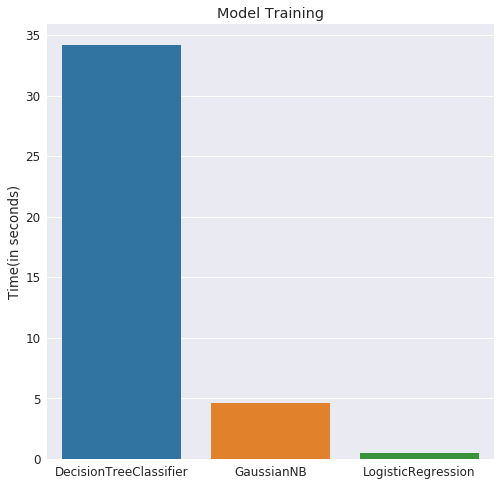

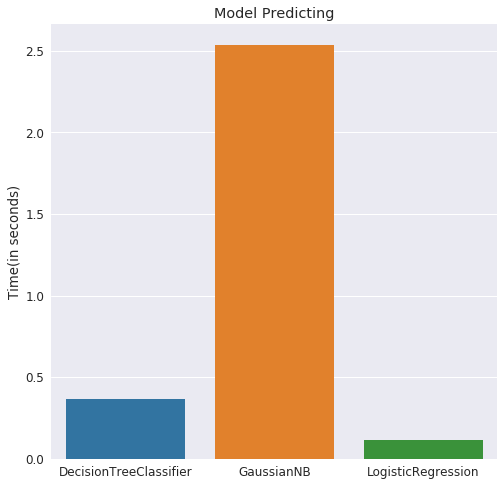

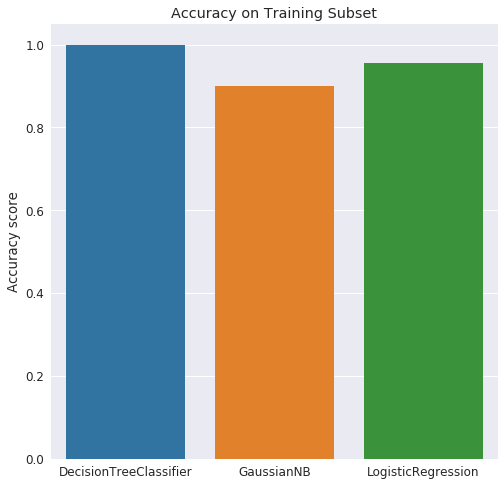

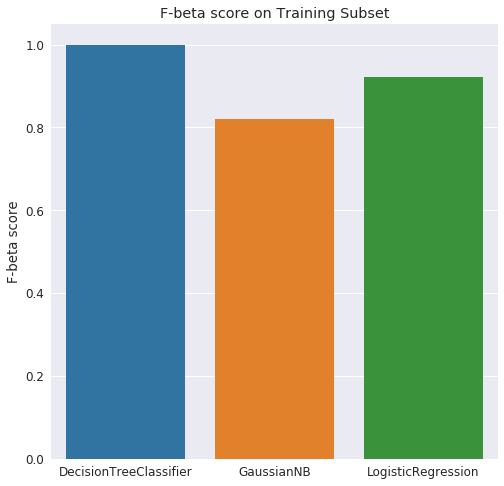

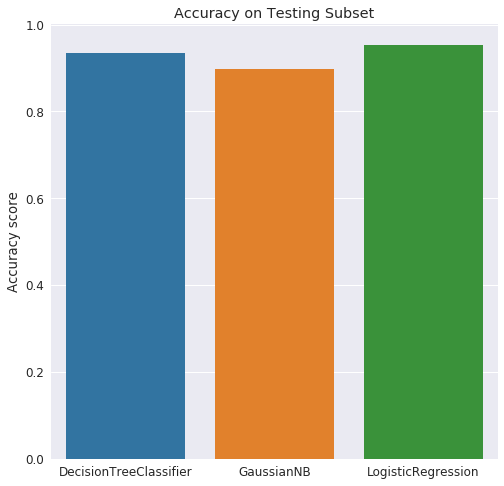

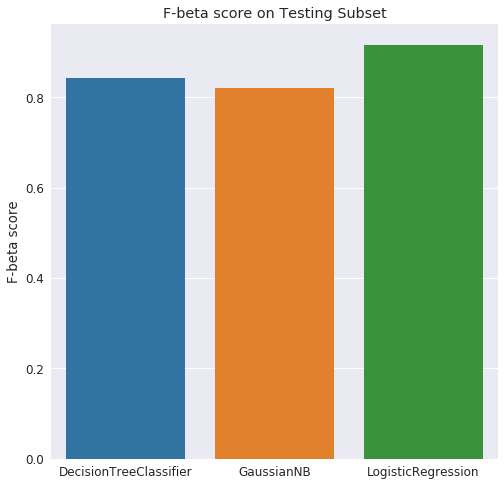

In [15]:
%matplotlib inline
for  metric in metrics.keys():    
    plt.figure(figsize=(8, 8))
    sns.set(font_scale=1.2)
    ax = sns.barplot([k for k in results.keys()], [results[learner][metric] for learner in results.keys()], palette=pal)
    ax.set( ylabel=metrics[metric], title=metric)

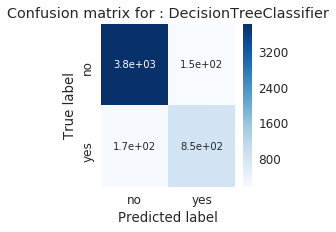

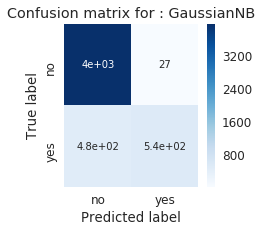

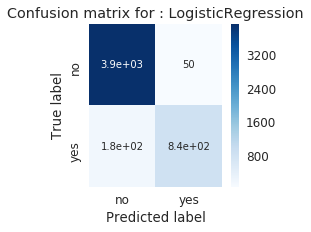

In [16]:
from sklearn.metrics import confusion_matrix
%matplotlib inline

for clf in predictors:
    # Compute confusion matrix for a model
    model = clf
    cm = confusion_matrix(y_test.values, model.predict(X_test))
    plt.figure(figsize=(3, 3))
    # view with a heatmap
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for : {}'.format(model.__class__.__name__));

----
## Model tuning

In [17]:
#https://github.com/udacity/machine-learning/tree/master/projects/finding_donors
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

# choose cross-validation iterator
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

# Initialize the classifier
clf = LogisticRegression(random_state = 42)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'C':np.logspace(-3,3,7)}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, cv=cv,param_grid=parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.9540
F-score on testing data: 0.9169

Optimized Model
------
Final accuracy score on the testing data: 0.9562
Final F-score on the testing data: 0.9201


----
## Feature importance analysis

In [18]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_ 

# Define the number of feature for importance analysis
FEATURE_NUMBER = 10

# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:FEATURE_NUMBER]]
values = importances[indices][:FEATURE_NUMBER]

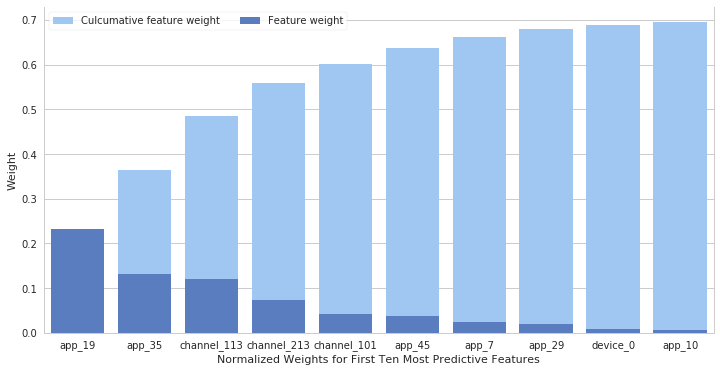

In [19]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(columns, np.cumsum(values), label="Culcumative feature weight", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(columns, values, label="Feature weight", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper left", frameon=True)
ax.set( ylabel="Weight",
       xlabel="Normalized Weights for First Ten Most Predictive Features")
sns.despine( right=False)

In [20]:
#https://github.com/udacity/machine-learning/tree/master/projects/finding_donors
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:FEATURE_NUMBER]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:FEATURE_NUMBER]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.9562
F-score on testing data: 0.9201

Final Model trained on reduced data
------
Accuracy on testing data: 0.9426
F-score on testing data: 0.8985
